# Insights Deep-Dive

### By this point we have, converted csv files to .sqlite with load_data_sqlite.py. Explored, cleaned and prepared data in jupyternotebook and pandas (table_exploration_cleaning). Created table views based on the new member-level aggregates using table_join_views.ipynb. We can now proceed to uncover our insights!

In [1]:
# Run pip install ipython-sql
%load_ext sql

%sql sqlite:///database/clean_db.sqlite

# Run the next line if error
%config SqlMagic.style = '_DEPRECATED_DEFAULT' 

# sql to df for visualization
%config SqlMagic.autopandas = True

%sql SELECT name from sqlite_master where type='view';

 * sqlite:///database/clean_db.sqlite
Done.


,name
0,parent_member_view
1,parent_checkins
2,parent_classes
3,parent_finances
4,parent_pt
5,parent_pos


In [2]:
%sql select * from parent_member_view limit 2;

 * sqlite:///database/clean_db.sqlite
Done.


,member_id,gender,age,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days,eligible_105,churn_by_105
0,ABC1000,male,21.0,Standard Annual,2024-08-21 00:00:00,None,None,Active,378,1,0
1,ABC1001,female,40.0,Standard M2M,2024-01-04 00:00:00,2024-12-02 00:00:00,Relocation,Canceled,333,1,0


In [3]:
%sql select * from parent_checkins limit 2;

 * sqlite:///database/clean_db.sqlite
Done.


,member_id,gender,age,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days,eligible_105,churn_by_105,total_checkins,active_months,avg_checkins_per_month,most_frequent_day,most_common_hour,last_checkin_date,days_since_last_checkin,at_risk
0,ABC1000,male,21.0,Standard Annual,2024-08-21 00:00:00,None,None,Active,378,1,0,155,13,11.923077,Sunday,8,2025-08-28 00:00:00,6,0
1,ABC1001,female,40.0,Standard M2M,2024-01-04 00:00:00,2024-12-02 00:00:00,Relocation,Canceled,333,1,0,196,12,16.333333,Sunday,8,2024-12-02 00:00:00,275,1


In [4]:
%sql select * from parent_finances limit 2;

 * sqlite:///database/clean_db.sqlite
Done.


,member_id,gender,age,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days,eligible_105,churn_by_105,monthly_fee,payment_status_tendency,total_payments,lifetime_outstanding_balance
0,ABC1000,male,21.0,Standard Annual,2024-08-21 00:00:00,None,None,Active,378,1,0,55.00,on-time,15,0.00
1,ABC1001,female,40.0,Standard M2M,2024-01-04 00:00:00,2024-12-02 00:00:00,Relocation,Canceled,333,1,0,49.99,on-time,12,49.99


In [5]:
%sql select * from parent_classes limit 2;

 * sqlite:///database/clean_db.sqlite
Done.


,member_id,gender,age,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days,eligible_105,churn_by_105,total_classes,favorite_class,favorite_day,favorite_hour
0,ABC1000,male,21.0,Standard Annual,2024-08-21 00:00:00,None,None,Active,378,1,0,NaN,None,None,NaN
1,ABC1001,female,40.0,Standard M2M,2024-01-04 00:00:00,2024-12-02 00:00:00,Relocation,Canceled,333,1,0,7.0,yoga basics,Friday,6.0


In [6]:
%sql select * from parent_pt limit 2;

 * sqlite:///database/clean_db.sqlite
Done.


,member_id,gender,age,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days,eligible_105,churn_by_105,member_id:1,total_pt_sessions,favorite_pt_session,favorite_day,favorite_hour,latest_session
0,ABC1000,male,21.0,Standard Annual,2024-08-21 00:00:00,None,None,Active,378,1,0,None,None,None,None,None,None
1,ABC1001,female,40.0,Standard M2M,2024-01-04 00:00:00,2024-12-02 00:00:00,Relocation,Canceled,333,1,0,None,None,None,None,None,None


In [7]:
%sql select * from parent_pos limit 2;

 * sqlite:///database/clean_db.sqlite
Done.


,member_id,gender,age,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days,eligible_105,churn_by_105,member_id:1,total_items_bought,total_purchase_value,last_purchase_date
0,ABC1000,male,21.0,Standard Annual,2024-08-21 00:00:00,None,None,Active,378,1,0,ABC1000,4,34.0,2025-05-19 00:00:00
1,ABC1001,female,40.0,Standard M2M,2024-01-04 00:00:00,2024-12-02 00:00:00,Relocation,Canceled,333,1,0,ABC1001,2,17.0,2024-04-19 00:00:00


# SQL Queries

## Behavioral Analysis

### Average Monthly Check-Ins for active members (Retained)

In [8]:
%%sql
SELECT
    ROUND(AVG(avg_checkins_per_month), 2) as avg_monthly_checkins
FROM parent_checkins
WHERE status = 'Active'
AND eligible_105 = 1;

 * sqlite:///database/clean_db.sqlite
Done.


,avg_monthly_checkins
0,9.42


In [9]:
%%sql
SELECT
    ROUND(AVG(avg_checkins_per_month), 2) as avg_monthly_checkins
FROM parent_checkins
WHERE status = 'Canceled'
AND churn_by_105 = 1;

 * sqlite:///database/clean_db.sqlite
Done.


,avg_monthly_checkins
0,7.91


### Churn Likelihood by Agreement Type

In [10]:
%%sql
SELECT
    agreement_type,
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105
FROM parent_member_view
WHERE eligible_105 = 1
GROUP BY agreement_type
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


,agreement_type,churn_rate_by_105
0,Passport M2M,25.83
1,Standard M2M,18.90
2,Passport Annual,13.64
3,Standard Annual,11.56


### Churn Likelihood by Check-In Frequency

In [11]:
%%sql
SELECT
    CASE
        WHEN avg_checkins_per_month < 4 THEN 'Low (0–3)'
        WHEN avg_checkins_per_month BETWEEN 4 AND 10 THEN 'Medium (4–10)'
        ELSE 'High (11+)'
    END AS check_in_category,
    COUNT(*) AS members,
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105
FROM parent_checkins
WHERE eligible_105 = 1
GROUP BY check_in_category
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


,check_in_category,members,churn_rate_by_105
0,Low (0–3),93,43.01
1,High (11+),432,15.28
2,Medium (4–10),359,15.04


### Churn Likelihood by Inactive period

In [12]:
%%sql
SELECT
    inactive_category,
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105
FROM (
    SELECT
        member_id,
        eligible_105,
        churn_by_105,
        CASE
            WHEN days_since_last_checkin > 30 or
            days_since_last_checkin IS NULL THEN 'No check-in within 30 days'
            ELSE 'check-in within 30 days'
        END AS inactive_category
    FROM parent_checkins
) sub
WHERE eligible_105 = 1
GROUP BY inactive_category
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


,inactive_category,churn_rate_by_105
0,No check-in within 30 days,44.07
1,check-in within 30 days,5.09


### Churn Likelihood by Class Attendance

In [13]:
%%sql
SELECT
    class_attendance,
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105
FROM (
    SELECT
        member_id,
        eligible_105,
        churn_by_105,
        CASE
            WHEN total_classes > 0 THEN 'Attended Classes'
            ELSE 'No Classes'
        END AS class_attendance
    FROM parent_classes
) sub
WHERE eligible_105 = 1
GROUP BY class_attendance
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


,class_attendance,churn_rate_by_105
0,No Classes,21.26
1,Attended Classes,17.32


### Churn Likelihood by Personal Training Attendee

In [14]:
%%sql
SELECT 
    pt_attendance,
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105
FROM (
    SELECT 
        member_id,
        eligible_105,
        churn_by_105,
        CASE
            WHEN total_pt_sessions > 0 THEN 'Attended PT'
            ELSE 'No PT'
        END AS pt_attendance
    from parent_pt
) sub
WHERE eligible_105 = 1
GROUP BY pt_attendance
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


,pt_attendance,churn_rate_by_105
0,No PT,19.1
1,Attended PT,12.0


### Churn Likelihood by Purchase

In [15]:
%%sql
SELECT
    purchase_category,
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105
FROM (
    SELECT
        member_id,
        eligible_105,
        churn_by_105,
        CASE
            WHEN total_purchase_value > 0 then 'Made Purchases'
            ELSE 'No Purchases'
        END AS purchase_category
    from parent_pos
) sub
WHERE eligible_105 = 1
GROUP BY purchase_category
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


,purchase_category,churn_rate_by_105
0,No Purchases,28.26
1,Made Purchases,16.92


### Churn Likelihood by Late Payments.

In [16]:
%%sql
SELECT
    payment_status_tendency,
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105
FROM parent_finances
WHERE eligible_105 = 1
GROUP BY payment_status_tendency
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


,payment_status_tendency,churn_rate_by_105
0,late,100.00
1,on-time,14.32


# Helpful Visualizations

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

 * sqlite:///database/clean_db.sqlite
Done.


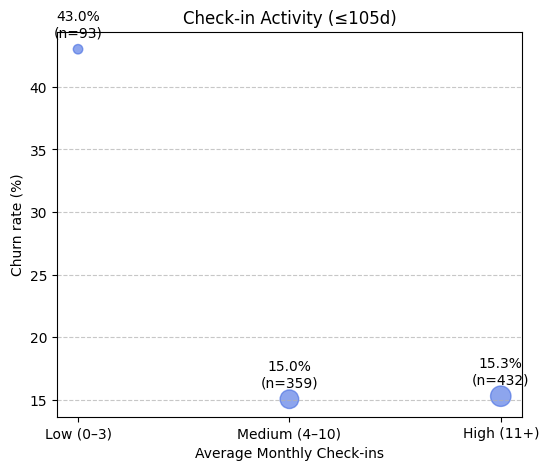

In [18]:
df = %sql \
SELECT \
    CASE \
        WHEN avg_checkins_per_month < 4 THEN 'Low (0–3)' \
        WHEN avg_checkins_per_month BETWEEN 4 AND 10 THEN 'Medium (4–10)' \
        ELSE 'High (11+)' \
    END AS check_in_category, \
    COUNT(*) AS members, \
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105 \
FROM parent_checkins \
WHERE eligible_105 = 1 \
GROUP BY check_in_category \
ORDER BY churn_rate_by_105 DESC;

order = ["Low (0–3)", "Medium (4–10)", "High (11+)"]
df = df.set_index("check_in_category").loc[order].reset_index()

plt.figure(figsize=(6,5))
plt.scatter(df["check_in_category"], df["churn_rate_by_105"],
            s=df["members"]*0.5, alpha=0.6, color="royalblue")

plt.title("Check-in Activity (≤105d)")
plt.ylabel("Churn rate (%)")
plt.xlabel("Average Monthly Check-ins")

# Add text labels
for xi, r, m in zip(df["check_in_category"], df["churn_rate_by_105"], df["members"]):
    plt.text(xi, r+1, f"{r:.1f}%\n(n={int(m)})", ha="center")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

 * sqlite:///database/clean_db.sqlite
Done.


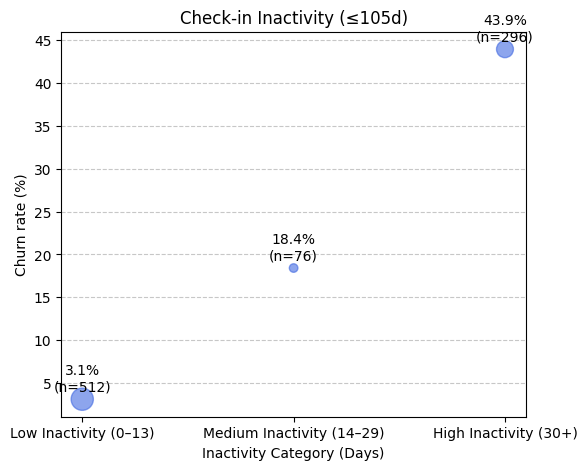

In [4]:
df_inactivity = %sql \
SELECT \
    CASE \
        WHEN days_since_last_checkin < 14 THEN 'Low Inactivity (0–13)' \
        WHEN days_since_last_checkin BETWEEN 14 AND 29 THEN 'Medium Inactivity (14–29)' \
        ELSE 'High Inactivity (30+)' \
    END AS inactivity_category, \
    COUNT(*) AS members, \
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105 \
FROM parent_checkins \
WHERE eligible_105 = 1 \
GROUP BY inactivity_category \
ORDER BY churn_rate_by_105 DESC;

order = ["Low Inactivity (0–13)", "Medium Inactivity (14–29)", "High Inactivity (30+)"]
df_inactivity = df_inactivity.set_index("inactivity_category").loc[order].reset_index()

plt.figure(figsize=(6,5))
plt.scatter(df_inactivity["inactivity_category"], df_inactivity["churn_rate_by_105"],
            s=df_inactivity["members"]*0.5, alpha=0.6, color="royalblue")

plt.title("Check-in Inactivity (≤105d)")
plt.ylabel("Churn rate (%)")
plt.xlabel("Inactivity Category (Days)")

# Add text labels
for xi, r, m in zip(df_inactivity["inactivity_category"], df_inactivity["churn_rate_by_105"], df_inactivity["members"]):
    plt.text(xi, r+1, f"{r:.1f}%\n(n={int(m)})", ha="center")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

 * sqlite:///database/clean_db.sqlite
Done.


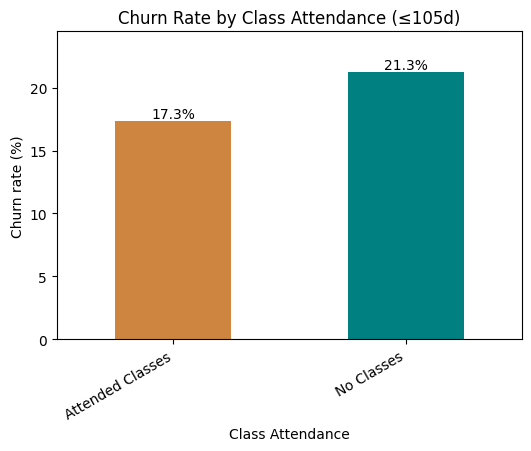

In [27]:
df_class = %sql \
SELECT \
    CASE WHEN total_classes > 0 THEN 'Attended Classes' ELSE 'No Classes' END AS class_attendance, \
    COUNT(*) AS members, \
    ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105 \
FROM parent_classes \
WHERE eligible_105 = 1 \
GROUP BY class_attendance;

ax = df_class.plot(x="class_attendance", y="churn_rate_by_105", kind="bar", figsize=(6,4), color=["peru", "teal"], legend=False)
ax.bar_label(ax.containers[0], fmt="%.1f%%")
ax.set_ylim(0, df_class["churn_rate_by_105"].max() * 1.15)
ax.set_title("Churn Rate by Class Attendance (≤105d)")
ax.set_ylabel("Churn rate (%)")
ax.set_xlabel("Class Attendance")
plt.xticks(rotation=30, ha="right")
plt.show()

 * sqlite:///database/clean_db.sqlite
Done.


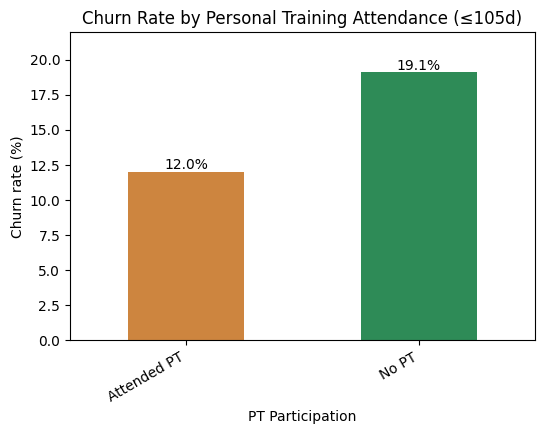

In [28]:
df_pt = %sql \
SELECT \
  CASE WHEN IFNULL(total_pt_sessions,0) > 0 \
       THEN 'Attended PT' ELSE 'No PT' END AS pt_attendance, \
  COUNT(*) AS members, \
  ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105 \
FROM parent_pt \
WHERE eligible_105 = 1 \
GROUP BY pt_attendance \
ORDER BY churn_rate_by_105 ASC;

ax = df_pt.plot(x="pt_attendance", y="churn_rate_by_105", kind="bar", figsize=(6,4), color=["peru", "seagreen"], legend=False)
ax.bar_label(ax.containers[0], fmt="%.1f%%")
ax.set_ylim(0, df_pt["churn_rate_by_105"].max() * 1.15)
ax.set_title("Churn Rate by Personal Training Attendance (≤105d)")
ax.set_ylabel("Churn rate (%)")
ax.set_xlabel("PT Participation")
plt.xticks(rotation=30, ha="right")
plt.show()

In [23]:
df_class_pt = %sql \
WITH base AS ( \
  SELECT \
    m.member_id, \
    m.eligible_105, \
    m.churn_by_105, \
    CASE WHEN IFNULL(c.total_classes, 0) > 0 THEN 'Attended Classes' ELSE 'No Classes' END AS class_attendance, \
    CASE WHEN IFNULL(p.total_pt_sessions, 0) > 0 THEN 'Attended PT'     ELSE 'No PT'     END AS pt_attendance \
  FROM parent_member_view AS m \
  LEFT JOIN parent_classes AS c USING (member_id) \
  LEFT JOIN parent_pt      AS p USING (member_id) \
  GROUP BY m.member_id \
) \
SELECT \
  class_attendance, \
  pt_attendance, \
  COUNT(*) AS members, \
  SUM(churn_by_105) AS early_canceled_members, \
  ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105 \
FROM base \
WHERE eligible_105 = 1 \
GROUP BY class_attendance, pt_attendance \
ORDER BY churn_rate_by_105 ASC;

 * sqlite:///database/clean_db.sqlite
Done.


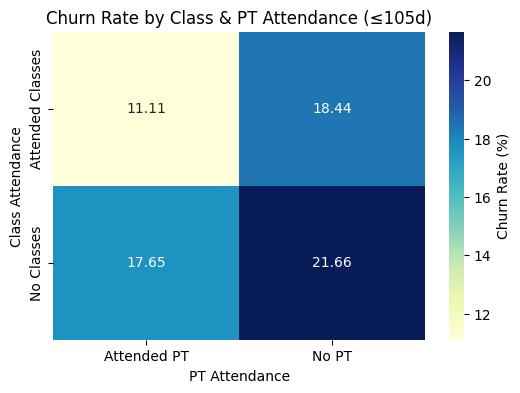

In [24]:
pivot = df_class_pt.pivot(index="class_attendance", 
                          columns="pt_attendance", 
                          values="churn_rate_by_105")

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", 
            cbar_kws={"label": "Churn Rate (%)"})
plt.title("Churn Rate by Class & PT Attendance (≤105d)")
plt.ylabel("Class Attendance")
plt.xlabel("PT Attendance")
plt.show()

 * sqlite:///database/clean_db.sqlite
Done.


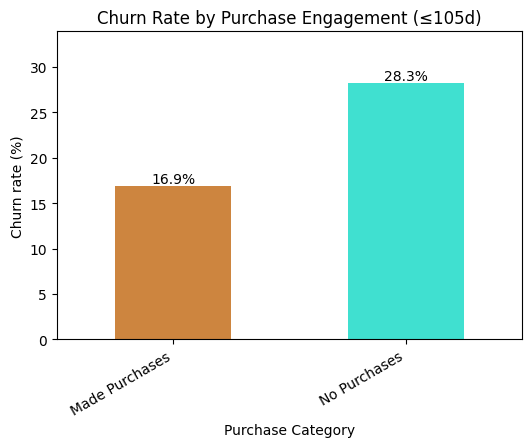

In [31]:
df_pos = %sql \
SELECT \
  CASE WHEN total_purchase_value > 0 THEN 'Made Purchases' ELSE 'No Purchases' END AS purchase_category, \
  COUNT(*) AS members, \
  ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105 \
FROM parent_pos \
WHERE eligible_105 = 1 \
GROUP BY purchase_category;

ax = df_pos.plot(x="purchase_category", y="churn_rate_by_105", kind="bar", figsize=(6,4), color=["peru", "turquoise"], legend=False)
ax.bar_label(ax.containers[0], fmt="%.1f%%")
ax.set_ylim(0, df_pos["churn_rate_by_105"].max() * 1.2)
ax.set_title("Churn Rate by Purchase Engagement (≤105d)")
ax.set_ylabel("Churn rate (%)")
ax.set_xlabel("Purchase Category")
plt.xticks(rotation=30, ha="right")
plt.show()

 * sqlite:///database/clean_db.sqlite
Done.


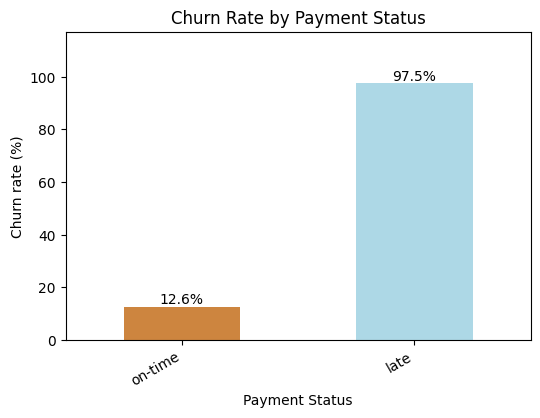

In [32]:
df_payment = %sql \
SELECT payment_status_tendency, \
       COUNT(*) AS members, \
       ROUND(SUM(CASE WHEN status='Canceled' and tenure_days <= 105 THEN 1 ELSE 0 END)*100.0/COUNT(*),2) AS churn_rate \
FROM parent_finances \
GROUP BY payment_status_tendency \
ORDER BY payment_status_tendency desc;


ax = df_payment.plot(x="payment_status_tendency", y="churn_rate", kind="bar", figsize=(6,4), color=["peru", "lightblue"], legend=False)
ax.bar_label(ax.containers[0], fmt="%.1f%%")
ax.set_ylim(0, df_payment["churn_rate"].max() * 1.2)
ax.set_title("Churn Rate by Payment Status")
ax.set_ylabel("Churn rate (%)")
ax.set_xlabel("Payment Status")
plt.xticks(rotation=30, ha="right")
plt.show()

In [33]:
df_behavior = %sql \
WITH base AS ( \
  SELECT \
    m.member_id, m.status, m.agreement_type, \
    m.eligible_105, m.churn_by_105, \
    COALESCE(pur.avg_checkins_per_month, 0) AS avg_checkins_per_month \
  FROM parent_member_view m \
  LEFT JOIN parent_checkins pur USING (member_id) \
), \
features AS ( \
  SELECT \
    member_id, status, agreement_type, eligible_105, churn_by_105, \
    CASE \
      WHEN avg_checkins_per_month < 4 THEN 'Low (0–3)' \
      WHEN avg_checkins_per_month BETWEEN 4 AND 12 THEN 'Medium (4–12)' \
      ELSE 'High (13+)' \
    END AS checkin_bucket \
  FROM base \
) \
SELECT \
  agreement_type, \
  checkin_bucket, \
  COUNT(*) AS members, \
  ROUND(AVG(churn_by_105) * 100.0, 2) AS churn_rate_by_105 \
FROM features \
WHERE eligible_105 = 1 \
GROUP BY agreement_type, checkin_bucket \
ORDER BY churn_rate_by_105 DESC;

 * sqlite:///database/clean_db.sqlite
Done.


In [34]:
df_behavior

,agreement_type,checkin_bucket,members,churn_rate_by_105
0,Passport Annual,Low (0–3),7,71.43
1,Standard Annual,Low (0–3),8,50.00
2,Passport M2M,Low (0–3),15,46.67
3,Standard M2M,Low (0–3),63,38.10
4,Passport M2M,Medium (4–12),72,29.17
5,Standard M2M,Medium (4–12),326,19.94
6,Passport Annual,Medium (4–12),52,11.54
7,Standard Annual,Medium (4–12),90,10.00
8,Passport M2M,High (13+),33,9.09
9,Standard Annual,High (13+),49,8.16


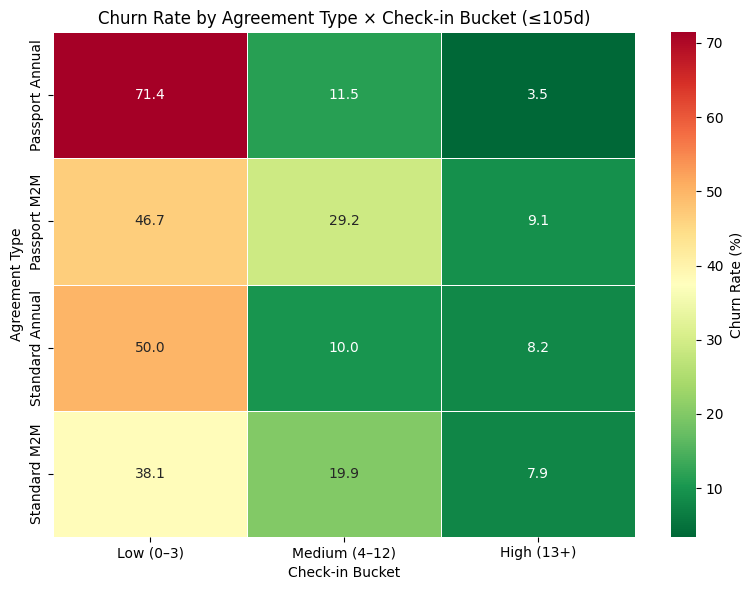

In [35]:
pivot = (
    df_behavior
      .groupby(["agreement_type","checkin_bucket"], as_index=False)["churn_rate_by_105"]
      .mean()
      .pivot(index="agreement_type", columns="checkin_bucket", values="churn_rate_by_105")
)

bucket_order = ["Low (0–3)", "Medium (4–12)", "High (13+)"]
pivot = pivot[bucket_order]

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot, annot=True, fmt=".1f",
    cmap="RdYlGn_r", cbar_kws={"label":"Churn Rate (%)"},
    linewidths=0.5, linecolor="white"
)
plt.title("Churn Rate by Agreement Type × Check-in Bucket (≤105d)")
plt.ylabel("Agreement Type")
plt.xlabel("Check-in Bucket")
plt.tight_layout()
plt.show()